In [1]:
using Causality, IntervalUnionArithmetic

# Generation of Epidemics

In [24]:
T, N = 40., 200
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,3/N)
G.A 

200×200 SparseArrays.SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 1692 stored entries:
⠠⠂⢀⢐⡂⠈⠈⢇⢀⠀⠀⡸⠶⠌⠀⡁⠀⣀⢎⢌⠇⠂⢈⠈⠀⠨⡄⡁⢄⢰⡀⡐⣀⠀⠑⢈⠀⠀⠀⠀
⢀⢐⠀⠀⡀⢄⠔⢠⢠⡤⠁⢁⠠⠈⢱⠊⠬⢮⠂⠔⠀⠀⢆⠂⠁⠈⠣⠄⡒⢃⠠⢂⠂⠍⢰⠤⢡⠚⠐⠉
⡈⠈⠀⢌⢀⠐⡣⡈⡊⡇⠈⢂⠠⠈⠠⠀⠀⠠⠀⠌⣑⠉⠈⠌⠁⢀⠠⠂⠀⠉⠁⢘⠔⠰⡡⠀⢚⠱⠄⡊
⠦⢄⠐⣁⡉⠪⣀⠘⢁⠂⣙⠡⠒⠀⠈⠂⡀⢀⠀⠐⡌⠀⠁⢆⢀⠀⠀⡁⠐⡑⣨⢊⠠⢑⣑⠑⢈⡐⡃⣙
⠀⠐⠀⡶⠮⠬⠡⠐⢀⠐⢀⢑⠰⡀⢢⢐⠒⠲⠀⡅⠨⢒⠥⠀⢐⡀⢨⣂⠒⠐⡂⡨⠈⡨⢠⠐⢡⠊⠄⠍
⣀⡠⠅⢀⠢⢀⠗⡘⢄⢐⠄⠁⠪⠀⠼⢄⣂⢄⡀⠀⡂⡐⢀⠐⠐⠂⠄⡐⡀⠂⡊⣀⠦⠱⠒⢥⠔⠠⠂⠕
⡘⠇⡀⠂⡀⠂⠘⠀⠐⠢⠊⠂⠎⠁⡐⢀⠒⢒⢃⢀⡀⠠⢀⢢⡤⠤⠁⣠⠍⡀⠀⠀⠁⣐⢜⢒⠀⠈⠂⠠
⠄⠠⡱⠒⠀⠂⠢⠀⢈⢒⠒⢇⠐⢈⡀⠌⣁⠞⢠⢢⠀⡀⡂⠂⡀⠀⠅⡄⠠⡁⡁⡄⠆⠉⠰⢪⡐⣠⢀⠊
⠀⢠⡢⣇⠀⡀⠀⢈⢸⡀⠈⢜⢸⢀⣡⠜⣾⡻⠀⠀⠂⡇⠐⠀⠈⠀⡔⠀⠂⡀⡃⠔⠠⣀⢠⣾⢎⠀⠀⢀
⡊⢕⢈⠄⡀⠄⢀⠀⠄⠤⠀⠈⠉⢐⠠⣒⠀⠀⣀⠘⡑⡂⢔⢒⡢⠳⣢⡂⣝⡁⡀⡁⠂⠀⡈⣐⠀⣙⢈⠐
⠩⠁⠀⠀⡕⠘⠂⠉⢢⢂⢈⠨⠀⡈⠀⠠⠬⠤⠱⠨⠄⠁⠠⠚⢇⡒⠪⢀⠄⠩⡄⠰⠂⠂⠁⠍⢔⡥⠀⠒
⡂⠐⠨⠑⡂⠄⠡⢄⠁⠃⢀⠐⠠⣐⠨⠈⠐⠀⢰⢑⣠⠂⢄⠑⣠⣀⡊⡂⠒⡁⡢⠘⡧⡤⡀⢐⠀⠀⠌⢈
⡀⡀⡁⠀⠁⢀⠀⠐⠐⠰⠰⠀⠀⡏⠀⠈⠂⠀⢬⡊⢩⠱⠀⢺⡤⡫⡙⠠⡅⠀⠀⠄⡅⣉⡀⠁⠰⠋⠨⢨
⠄⠩⠉⠆⠠⠂⠄⠠⠢⢲⢀⠡⠁⣠⠁⠥⠐⠉⠨⠺⠊⢂⠪⠨⠓⡈⠄⠁⠨⡁⠤⠕⠍⡉⢀⠪⢢⠂⠐⠌
⢀⣑⠼⢈⡄⠀⢔⠠⢘⠀⠠⠈⠃⠡⠄⠢⠈⠠⠗⠹⡄⡁⠜⠠⠁⠉⠆⠢⠄⠁⡄⠋⠂⠤⠵⡐⠀⠕⠨⠠
⢀⠨⠠⢂⣁⢀⡢⢚⡈⡨⠊⢨⠀⠀⠁⠬⢉⠌⠄⠨⢀⡉⣈⠊⠀⠄⢄⠇⡤⠉⠄⠁⠐⠂⡡⠈⠐⠡⠠⢀
⠀⠘⡌⠄⢐⡁⢄⢂⡂⡠⢌⡃⢁⢠⡌⠁⠀⢢⠈⠀⠨⠀⠉⡯⡅⢩⡇⠡⠈⡄⠰⠀⣊⡸⢡⢘⣂⢐⡀⢨
⡑⢀⠐⡖⠁⠊⢕⠘⢀⠒⠜⣄⢲⢑⡰⣂⣠⣶⢂⢨⡅⠄⢀⢈⠄⠈⡠⡐⢑⠣⡁⠊⣁⢒⠀⠀⡐⠔⠁⠌
⠀⠀⣡⠒⢞⡐⢂⠰⡡⠒⠐⡁⡀⠀⠐⣨⠊⠑⣄⢠⠔⡵⠀⠀⡴⠂⠨⠒⢄⠄⠔⡀⢈⢘⢐⠌⡀⠈⠠⠂
⠀⠀⡔⠀⡠⠡⣍⢨⡄⠅⢌⠄⠈⡀⡠⠐⠀⢀⢂⠐⢠⠀⡂⢁⡂⣂⡐⠄⠂⡂⠀⢂⡀⣈⡁⠄⠠⠂⡐⠈

In [25]:
getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate, lat_gen::GaussianRate, rec_gen::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c lat_gen.a lat_gen.b lat_gen.c rec_gen.a rec_gen.b rec_gen.c]

getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate, latency::GaussianRate, recov::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
     fill(latency.a, 1, N); fill(latency.b, 1, N); fill(latency.c, 1, N);
     fill(recov.a, 1, N); fill(recov.b, 1, N); fill(recov.c, 1, N)
    ]

getparSI(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargenSI(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]



getpargenSI (generic function with 1 method)

In [26]:
#Initialize generation parameters
ε = 1e-10
λ = 0.1

pseed = 1/N 
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
latency = GaussianRate(1., T/2, 1/ε)
recov = GaussianRate(1., T/2, 1/ε)

inf_out = GaussianRate(λ, T/2, 1/ε)
l_delay = GaussianRate(0.4, T/2, 1/ε)
r_delay = GaussianRate(0.07, T/2, 1/ε)


#=inf_out = GaussianRate(λ, T/2, 2T)
l_delay = GaussianRate(0.57, 8., 5.)
r_delay = GaussianRate(0.23, 18., 10.)=#

θp = getpar(pseed, autoinf, inf_in, latency, recov);
θpgen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

In [27]:
const Igauss = GaussianInferentialSEIR
const Igen = GenerativeSEIR{GaussianRate,GaussianRate,GaussianRate,GaussianRate} 

GenerativeSEIR{GaussianRate, GaussianRate, GaussianRate, GaussianRate}

In [34]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N,3)
sample!(xtrue)
nobs, p = Int(round(N/3)), 1e-6
O = [(ti = T*rand(); i =rand(1:N) ; (i,xtrue[i,1] < ti ,ti,p)) for r=1:nobs]
sum(xtrue[:,1] .< T) / N
#xtrue

0.605

In [37]:
O

67-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (86, 1, 34.228726635164925, 1.0e-6)
 (182, 0, 0.7903807317859002, 1.0e-6)
 (11, 1, 36.93719315924283, 1.0e-6)
 (14, 0, 10.033654363820062, 1.0e-6)
 (28, 0, 11.53529877375127, 1.0e-6)
 (186, 0, 17.09709347537897, 1.0e-6)
 (133, 0, 12.743920289107757, 1.0e-6)
 (69, 0, 13.705046259395175, 1.0e-6)
 (2, 0, 26.40251114667814, 1.0e-6)
 (143, 1, 34.12856933314858, 1.0e-6)
 (75, 0, 3.5313167786509636, 1.0e-6)
 (189, 0, 37.383039583791096, 1.0e-6)
 (41, 0, 7.118607186961654, 1.0e-6)
 ⋮
 (141, 0, 2.96903926787635, 1.0e-6)
 (157, 0, 22.544895292914426, 1.0e-6)
 (149, 0, 11.23072922755667, 1.0e-6)
 (111, 1, 31.86898426013713, 1.0e-6)
 (54, 0, 17.38926193753242, 1.0e-6)
 (43, 1, 34.03317098279349, 1.0e-6)
 (110, 0, 29.143365154072157, 1.0e-6)
 (81, 1, 39.335937357340185, 1.0e-6)
 (97, 0, 28.798895796721627, 1.0e-6)
 (168, 0, 17.213338631771926, 1.0e-6)
 (8, 0, 14.004620209707731, 1.0e-6)
 (108, 0, 8.601353368899183, 1.0e-6)

## Inference with Causality (SEIR)

In [38]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min, rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max, rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

θp2 = getpar(pseed, autoinf, inf_in, latency, recov);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [39]:
#Initialize the parameters to learn

autoinf = GaussianRate(2e-3, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)
latency = GaussianRate(1., T/2, 2T)
recov = GaussianRate(1., T/2, 2T)


θ = getpar(pseed, autoinf, inf_in,  latency, recov);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [40]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2, O; M=M, numsamples=2000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[1,2,3,4,6,7,9,10,12,13]);
descend!(Mp2, O; M=M, numsamples=2000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[1,2,3,4,6,7,9,10,12,13]);



Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
  F:  52.01070762880623


In [41]:
rate_inf = M.θgen[5]
rate_lat = M.θgen[8]
rate_rec = M.θgen[11]

0.0037404807559942056

In [42]:
statscauSEIR = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## Inference with Causality (SI)

In [43]:
const IgenSI = GenerativeSI{GaussianRate,GaussianRate} 
const IgaussSI = GaussianInferentialSI
θmin = getparSI(pseed_min , rate_min, rate_min);
θmax = getparSI(pseed_max , rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargenSI(pseed_min, rate_min, rate_min);
θgenmax = getpargenSI(pseed_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargenSI(pseed, autoinf, inf_out);

θp2 = getparSI(pseed, autoinf, inf_in);
Mp2SI = StochasticModel(IgenSI, T, θp2, G, θp2gen);

In [44]:
#Initialize the parameters to learn

autoinf = GaussianRate(2e-3, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)


θ = getparSI(pseed, autoinf, inf_in);
MSI = StochasticModel(IgaussSI, T, θ, G, θp2gen);

In [45]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[1,2,3,4]);
descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[1,2,3,4]);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
  F:  66.88736780336448


In [46]:
statscauSI = prior(MSI);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## Check of Hyperparameters
we now see if the hyperparameters found are consistent with the prior distribution

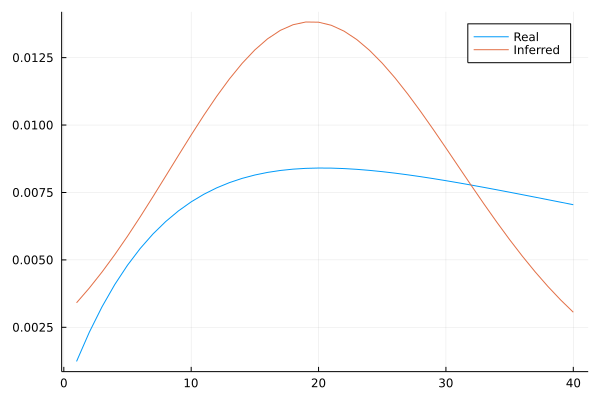

In [47]:
using Plots
inferred_inf = GaussianRate(MSI.θgen[5], MSI.θgen[6] , MSI.θgen[7])

real_trans = [rate_inf * rate_lat * exp(-(rate_inf+rate_rec)*t) *(exp((rate_inf-rate_lat+rate_rec)*t) - 1)/(rate_inf-rate_lat+rate_rec) for t=1:T]
inferred_trans=[Causality.density(inferred_inf,t) * exp(-Causality.cumulated(inferred_inf,t)) for t=1:T];

plot(real_trans, label = "Real")
plot!(inferred_trans,label="Inferred")
#savefig("comparisonHyperparams.pdf")

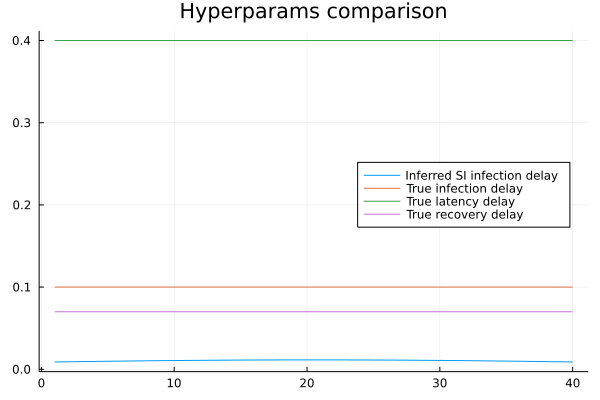

In [48]:
using Plots
x = LinRange(0,T,Int(T))
gauss(a,b,c,x) = a .* exp.(-((x .- b)/c) .^ 2)
plot(gauss(M.θgen[5], M.θgen[6] , M.θgen[7], x),label="Inferred SI infection delay",legend=:right,title="Hyperparams comparison")
plot!(gauss(inf_out.a,inf_out.b,inf_out.c,x),label="True infection delay")
plot!(gauss(l_delay.a, l_delay.b, l_delay.c,x),label="True latency delay ")
plot!(gauss(r_delay.a, r_delay.b, r_delay.c,x),label="True recovery delay ")
#plot!(gauss(0.47, 8., sqrt(3.56),x),label="True latency delay ")
#plot!(gauss(0.23, 16., sqrt(6.),x),label="True recovery delay ")
#savefig("Hyperparams_SEIRvsSI")

## Marginals and ROC curve

In [49]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i,1] .< t ) / numsamp
end

function marginalSI(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i] .< t ) / numsamp
end


function tpr(xtrue, rank) 
    den = sum(xtrue[rank])
    if den != 0
        return cumsum(xtrue[rank]) ./ den
    else
        return ones(size(rank))
    end
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

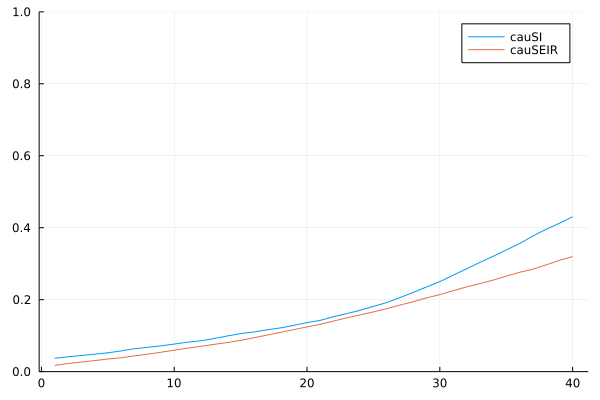

In [50]:
using Plots
p_cauSEIR = zeros(N,Int(T))
p_cauSI = zeros(N,Int(T))
for i = 1:N
    for t = 1:Int(T)
       p_cauSEIR[i,t] = marginal(i, t, statscauSEIR)
       p_cauSI[i,t] = marginalSI(i, t, statscauSI)
    end
end
i = 23
plot(p_cauSI[i,1:end], label = "cauSI")
plot!(p_cauSEIR[i,1:end], label = "cauSEIR")
#savefig("SEIRmarkov.pdf")
ylims!(0,1)

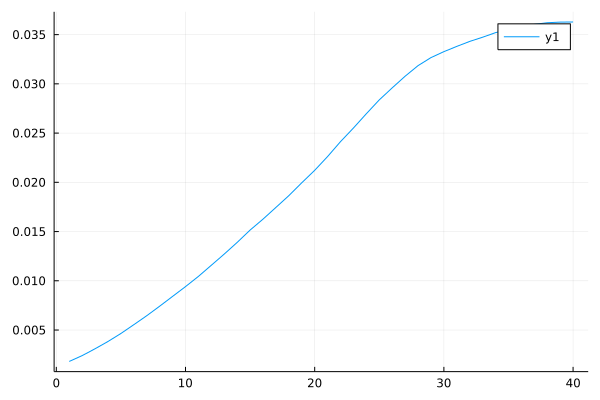

In [51]:
plot(sum((p_cauSI .- p_cauSEIR) .^ 2 / N,dims=1)')

In [52]:
[o for o in O if o[1] == 12]

Tuple{Int64, Bool, Float64, Float64}[]

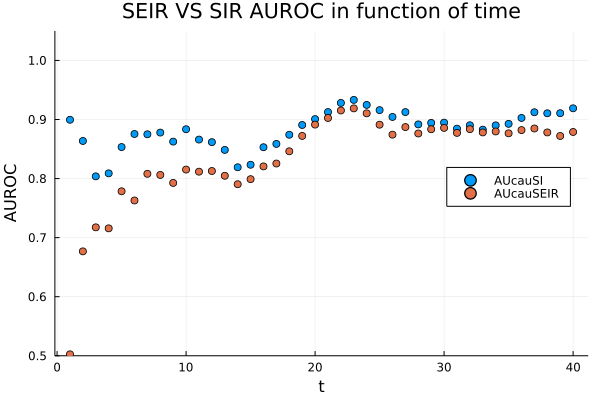

In [53]:
T = Int(T)
AU_cauSEIR=zeros(T)
AU_cauSI=zeros(T)
for t = 1:T
    cauSEIR_risk=zeros(N)
    cauSI_risk=zeros(N)
    for i=1:N
       cauSEIR_risk[i] = marginal(i,t,statscauSEIR)
       cauSI_risk[i] = marginalSI(i,t,statscauSI)
    end
    xt = xtrue[:,1] .< t-1e-3 
    AU_cauSEIR[t] = AUROC(ROC(xt, cauSEIR_risk))
    AU_cauSI[t] = AUROC(ROC(xt, cauSI_risk))
end

scatter(LinRange(1,T,T),AU_cauSI, label="AUcauSI",legend=:right)
scatter!(LinRange(1,T,T),AU_cauSEIR, label="AUcauSEIR", title="SEIR VS SIR AUROC in function of time")

T = Float64(T)
ylims!(0.5,1.05)
savefig("SierologicalAUROC")
xlabel!("t")
ylabel!("AUROC")